In [111]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt
from scipy.optimize import minimize
import sys

Set configuration to run code

In [112]:
flag_runlocal  = False    # "False" para ejecutar en google colab
flag_useserver = True    # "False" para ejecutar con conexión a internet via proxy

In [113]:
if flag_runlocal:
    # ---> Ejecución local
    pathBayesInfer = ''
    if flag_useserver:
        from ConfigProxy import proxy
        # Set the proxy with authentication
        import os
        os.environ['http_proxy'] = proxy
        os.environ['https_proxy'] = proxy

else:
    # ---> Desde github-to-colab
    !git clone https://github.com/Alledar/BayesInfer.git
    pathBayesInfer = '/content/BayesInfer/'

sys.path.append(pathBayesInfer+'02_Libraries')
import DSGEstuff as DG
import KFstuff as KF
from GeneralComplements import HP

fatal: destination path 'BayesInfer' already exists and is not an empty directory.


# Estimación de modelos de equilibrio general dinámico estocástico

Revisaremos los pasos de la estimación de manera secuencial

## El modelo: RBC simple

### El modelo tal como es derivado

El modelo incluye un conjunto de ecuaciones de equilibrio parcial

1. The Euler equation: $\frac{1}{\exp(u_t)}\frac{1}{C_t} = \beta E_t\left[ \frac{1}{C_{t+1}}\left(R_{t+1}+\frac{1-\delta}{\exp(u_{t+1})}\right)\right]$
2. Oferta de trabajo: $\phi H_t^\eta = W_tC_t^{-1}$
3. Restricciones tecnológicas de producción: $Y_t = \exp(z_t)K_{t-1}^\alpha H_t^{1-\alpha}$
4. Demanda de trabajo: $W_t = (1-\alpha)\frac{Y_t}{H_t}$
5. Demanda de capital: $R_t = \alpha \frac{Y_t}{K_{t-1}}$
6. Acumulación de capital: $K_{t} = (1-\delta)K_{t-1} + \exp(u_t) I_t$
7. Condición de limpieza de mercados: $Y_t = C_t + I_t$
8. Choque de productividad: $z_t = \rho_z z_{t-1} + \sigma_z\varepsilon_t^z$
9. Choque a la eficiencia de la inversión: $u_t = \rho_u u_{t-1} + \sigma_u\varepsilon_t^u$

### Categorización de variables
Adaptamos la notación de [Schmitt-Grohé y Uribe (2004)](https://www.sciencedirect.com/science/article/pii/S0165188903000435?casa_token=O2x0LFcDV5QAAAAA:FS5CqQvCF4e04X9hneh4vPV99AI3aMj3IwfqDMkxeku23zBFkXO1U2CZ_x76e1v0PFm5bZTMoQQ). En este paper, las variables del modelo se categorizan como se presenta a continuación

1. Variables endógenas: $\mathbf{Y}_t=[Y_t,\ C_t,\ I_t,\ H_t,\ W_t,\ R_t]'$
2. Variables de estado endógenos y/o rezagos: $\mathbf{X}_{1,t}=[K_{t-1}]$
3. Variables de estado exógenos: $\mathbf{X}_{2,t}=[z_t,\ u_t]'$
4. Variables de estado: $\mathbf{X}_{t}=[\mathbf{X}_{1t}',\ \mathbf{X}_{2t}]'$
5. Choques estructurales: : $\boldsymbol{\varepsilon}_t=[\varepsilon_t^z,\ \varepsilon_t^u]'$


### El sistema de expectativas racionales

En línea con [Schmitt-Grohé y Uribe (2004)](https://www.sciencedirect.com/science/article/pii/S0165188903000435?casa_token=O2x0LFcDV5QAAAAA:FS5CqQvCF4e04X9hneh4vPV99AI3aMj3IwfqDMkxeku23zBFkXO1U2CZ_x76e1v0PFm5bZTMoQQ), el DSGE no lineal se puede escribir como:

$$\mathrm{E}_t\mathbf{f}(\mathbf{Y}_{t+1},\mathbf{Y}_{t},\mathbf{X}_{t+1},\mathbf{X}_{t})=0$$
donde
$$\mathbf{X}_{2,t+1}=\Lambda \mathbf{X}_{2,t} + \tilde{\boldsymbol{\eta}}\boldsymbol{\varepsilon}_{t+1}$$

La solución (por perturbación) a este sistema tiene la forma
$$\mathbf{Y}_{t} = \mathbf{g}(\mathbf{X}_{t},\boldsymbol{\sigma})$$
$$\mathbf{X}_{t+1} = \mathbf{h}(\mathbf{X}_{t},\boldsymbol{\sigma})+\boldsymbol{\sigma}\boldsymbol{\eta}\boldsymbol{\varepsilon}_{t+1}\text{ con }\boldsymbol{\eta}=[\mathbf{0},\ \tilde{\boldsymbol{\eta}}']'$$

### El estado estacionario
El punto fijo del sistema se calcua resolviendo $\mathbf{Y}_{ss}$ y $\mathbf{X}_{ss}$ a partir de $\mathrm{E}_t\mathbf{f}(\mathbf{Y}_{ss},\mathbf{Y}_{ss},\mathbf{X}_{ss},\mathbf{X}_{ss})=0$
1. Tasa de interés real: $R_{ss} =\frac{1-\beta (1-\delta)}{\beta}$
2. Salario real: $W_{ss} = (1-\alpha)\left[\frac{1-\beta (1-\delta)}{\beta\alpha}\right]^{-\frac{\alpha}{1-\alpha}}$
3. Acevo de capital físico: $K_{ss} = \left[\frac{(1-\alpha)\beta\alpha}{\phi(1-\beta (1-\delta+\alpha\delta))}\right]^{\frac{1}{1+\eta}}\left[\frac{1-\beta (1-\delta)}{\beta\alpha}\right]^{-\frac{\alpha+\eta}{(1+\eta)(1-\alpha)}}$
4. Producción: $Y_{ss} = \frac{1-\beta (1-\delta)}{\beta\alpha}K_{ss}$
5. Inversión: $I_{ss} = \delta K_{ss}$
6. Consumo: $C_{ss} = \frac{1-\beta (1-\delta+\alpha\delta)}{\beta\alpha}K_{ss}$
7. Trabajo: $H_{ss} = \left[\frac{1-\beta (1-\delta)}{\beta\alpha}\right]^{\frac{1}{1-\alpha}}K_{ss}$
8. Choque de productividad: $Z_{ss}=1$
9. Choque de efectividad de la inversión: $U_{ss}=1$

### El sistema log-linearizado
Considere la siguiente transformación para una variable cualquiera $M_t$: $M_t=M_{ss}\exp(m_t)$ entonces $m_t$ es el desvío porcentual de $M_t$ respecto de su estado estacionario $M_{ss}$. Esto debido a que $m_t=\log\frac{M_t}{M_{ss}}$.

Así, si reemplazamos a todas las variables (sea esta $M_t$) por su equivalente en desvíos (esto es, $M_{ss}\exp(m_t)$) en el sistema no lineal de arriba. Así, luego de calcular la aproximación e Taylor de primer orden para cada ecuación se genera el siguiente sistema lineal:

1. Ecuación de Euler: $c_t = E_tc_{t+1}-[1-\beta (1-\delta)]E_tr_{t+1}+[\beta(1-\delta)\rho_\mu-1]u_{t}$
2. Oferta de trabajo: $\eta h_t = w_t - c_t$
3. Restricciones tecnológicas de producción: $y_t = z_t+\alpha k_{t-1}+ (1-\alpha)h_t$
4. Demanda de trabajo: $w_t = y_t-h_t$
5. Demanda de capital: $r_t = y_t-k_{t-1}$
6. Acumulación de capital: $k_{t} = (1-\delta)k_{t-1} +\delta i_t + \delta u_t$
7. Condición de limpieza de mercados: $y_t = \frac{1-\beta (1-\delta+\alpha\delta)}{1-\beta (1-\delta)} c_t + \frac{\delta\beta\alpha}{1-\beta (1-\delta)} i_t$
8. Choque de productividad: $z_t = \rho_z z_{t-1} + \sigma_z\varepsilon_t^z$
9. Choque a la eficiencia de la inversión: $u_t = \rho_\mu u_{t-1} + \sigma_u\varepsilon_t^u$

Por lo tanto, las variables quedan categorizadas de la siguiente manera
1. Variables endógenas: $\mathbf{y}_t=[y_t,\ c_t,\ i_t,\ h_t,\ w_t,\ r_t]'$
2. Variables de estado endógenos y/o rezagos: $\mathbf{x}_{1,t}=[k_{t-1}]$
3. Variables de estado exógenos: $\mathbf{x}_{2,t}=[z_{t},\ u_{t}]'$
4. Variables de estado: $\mathbf{x}_{t}=[k_{t-1},\ z_t,\ u_t]'$
5. Choques estructurales: : $\boldsymbol{\varepsilon}_t=[\varepsilon_t^z,\ \varepsilon_t^u]'$



### El sistema lineal de expectativas racionales (SLER)
Regresamos a la notación de [Schmitt-Grohé y Uribe (2004)](https://www.sciencedirect.com/science/article/pii/S0165188903000435?casa_token=O2x0LFcDV5QAAAAA:FS5CqQvCF4e04X9hneh4vPV99AI3aMj3IwfqDMkxeku23zBFkXO1U2CZ_x76e1v0PFm5bZTMoQQ). Así, definamos $\mathbf{f}_{y'}=\frac{\partial \mathbf{f}(\mathbf{Y}_{t+1},\mathbf{Y}_{t},\mathbf{X}_{t+1},\mathbf{X}_{t})}{\partial \mathbf{y}_{t+1}}\big|_{ss}$, $\mathbf{f}_{y}=\frac{\partial \mathbf{f}(\mathbf{Y}_{t+1},\mathbf{Y}_{t},\mathbf{X}_{t+1},\mathbf{X}_{t})}{\partial \mathbf{y}_{t}}\big|_{ss}$, $\mathbf{f}_{x'}=\frac{\partial \mathbf{f}(\mathbf{Y}_{t+1},\mathbf{Y}_{t},\mathbf{X}_{t+1},\mathbf{X}_{t})}{\partial \mathbf{x}_{t+1}}\big|_{ss}$ y $\mathbf{f}_{x}=\frac{\partial \mathbf{f}(\mathbf{Y}_{t+1},\mathbf{Y}_{t},\mathbf{X}_{t+1},\mathbf{X}_{t})}{\partial \mathbf{x}_{t}}\big|_{ss}$. Así, el modelo linearizado se puede escribir como:

$$\mathrm{E}_t\left[\mathbf{f}_{y'}\mathbf{y}_{t+1}+\mathbf{f}_{y}\mathbf{y}_{t}+\mathbf{f}_{x'}\mathbf{x}_{t+1}+\mathbf{f}_{x}\mathbf{x}_{t}\right]=0$$
donde
$$\mathbf{x}_{2,t+1}=\Lambda \mathbf{x}_{2,t} + \tilde{\boldsymbol{\eta}}\boldsymbol{\varepsilon}_{t+1}$$

Solución
$$\mathbf{y}_{t} = \mathbf{g}_x\mathbf{x}_{t}$$
$$\mathbf{x}_{t+1} = \mathbf{h}_x\mathbf{x}_{t}+\boldsymbol{\eta}\boldsymbol{\varepsilon}_{t+1}$$

* Identificando $\mathbf{f}_{y'},\ \mathbf{f}_{y},\ \mathbf{f}_{x'},\ \mathbf{f}_{x}$ a partir de la versión loglinear del modelo
$$\mathbf{f}_{y'}=\begin{bmatrix} 0 & 1 & 0 & 0 & 0 & -(1-\beta(1-\delta))\\
                                  0 & 0 & 0 & 0 & 0 & 0 \\
                                  0 & 0 & 0 & 0 & 0 & 0 \\
                                  0 & 0 & 0 & 0 & 0 & 0 \\
                                  0 & 0 & 0 & 0 & 0 & 0 \\
                                  0 & 0 & 0 & 0 & 0 & 0 \\
                                  0 & 0 & 0 & 0 & 0 & 0 \\
                                  0 & 0 & 0 & 0 & 0 & 0 \\
                                  0 & 0 & 0 & 0 & 0 & 0 \end{bmatrix},$$
  
$$\mathbf{f}_{y}=\begin{bmatrix}  0 & -1 & 0 & 0 & 0 & 0\\
                                  0 & -1 & 0 & -\eta & 1 & 0 \\
                                 -1 & 0 & 0 & (1-\alpha) & 0 & 0 \\
                                  1 & 0 & 0 & -1 & -1 & 0 \\
                                  1 & 0 & 0 & 0 & 0 & -1 \\
                                  0 & 0 & \delta & 0 & 0 & 0 \\
                                  -1 & \frac{1-\beta (1-\delta+\alpha\delta)}{1-\beta (1-\delta)} & \frac{\delta\beta\alpha}{1-\beta (1-\delta)} & 0 & 0 & 0 \\
                                  0 & 0 & 0 & 0 & 0 & 0 \\
                                  0 & 0 & 0 & 0 & 0 & 0 \\
                                  \end{bmatrix}$$

$$\mathbf{f}_{x'}=\begin{bmatrix} 0 & 0 & 0 \\
                                  0 & 0 & 0 \\
                                  0 & 0 & 0 \\
                                  0 & 0 & 0 \\
                                  0 & 0 & 0 \\
                                 -1 & 0 & 0 \\
                                  0 & 0 & 0 \\
                                  0 &-1 & 0 \\
                                  0 & 0 &-1 \\
                                  \end{bmatrix},\
  \mathbf{f}_{x} =\begin{bmatrix} 0 & 0 & \beta(1-\delta)\rho_\mu-1 \\
                                  0 & 0 & 0 \\
                                  \alpha & 1 & 0 \\
                                  0 & 0 & 0 \\
                                  -1 & 0 & 0 \\
                                 1-\delta & 0 & \delta \\
                                  0 & 0 & 0 \\
                                  0 & \rho_z & 0 \\
                                  0 & 0 & \rho_u \end{bmatrix}$$

In [114]:
# Calibración inicial
ALPHA_0   = 0.33
BETA_0    = 0.99
DELTA_0   = 0.025
ETA_0     = 0.5
RHOz_0    = 0.95
RHOu_0    = 0.95
SIGMAz_0  = 0.1
SIGMAu_0  = 0.1

param_0 = np.array([[ALPHA_0],[BETA_0],[DELTA_0],[ETA_0],[RHOz_0],[RHOu_0],[SIGMAz_0],[SIGMAu_0]])

In [185]:
param_0

array([[0.33 ],
       [0.99 ],
       [0.025],
       [0.5  ],
       [0.95 ],
       [0.95 ],
       [0.1  ],
       [0.1  ]])

In [115]:
def RBCveranoBCRP(param):
    # Unpack parameters
    ALPHA   = param[0].item()
    BETA    = param[1].item()
    DELTA   = param[2].item()
    ETA     = param[3].item()
    RHOz    = param[4].item()
    RHOu    = param[5].item()
    SIGMAz  = param[6].item()
    SIGMAu  = param[7].item()
    # fyp
    fyp = np.zeros(shape=(9,6))
    fyp[0,1] = 1
    fyp[0,5] = -(1-BETA*(1-DELTA))
    # fy
    fy = np.zeros(shape=(9,6))
    fy[0,1] = -1
    fy[1,1] = -1
    fy[1,3] = -ETA
    fy[1,4] =  1
    fy[2,0] = -1
    fy[2,3] = 1-ALPHA
    fy[3,0] = 1
    fy[3,3] = -1
    fy[3,4] = -1
    fy[4,0] = 1
    fy[4,5] = -1
    fy[5,2] = DELTA
    fy[6,0] = -1
    fy[6,1] = (1-BETA*(1-DELTA+ALPHA*DELTA))/(1-BETA*(1-DELTA))
    fy[6,2] = (DELTA*BETA*ALPHA)/(1-BETA*(1-DELTA))
    # fxp
    fxp = np.zeros(shape=(9,3))
    fxp[5,0] = -1
    fxp[7,1] = -1
    fxp[8,2] = -1
    # fx
    fx = np.zeros(shape=(9,3))
    fx[0,2] = BETA*(1-DELTA)*RHOu-1
    fx[2,0] = ALPHA
    fx[2,1] = 1
    fx[4,0] = -1
    fx[5,0] = 1-DELTA
    fx[5,2] = DELTA
    fx[7,1] = RHOz
    fx[8,2] = RHOu
    # Lambda
    Lambda = np.zeros(shape=(2,2))
    Lambda[0,0] = RHOz
    Lambda[1,1] = RHOu
    # Eta
    Eta = np.zeros(shape=(3,2))
    Eta[1,0] = SIGMAz
    Eta[2,1] = SIGMAu
    return {'fyp':fyp,'fy':fy,'fxp':fxp,'fx':fx,'Lambda':Lambda,'Eta':Eta} ### me resgresa un diccionario

In [183]:
# En la calibración inicial
modelo = dict()
modelo['SLER'] = RBCveranoBCRP(param_0) #dar inputs necesarios

### Solución del SLER (sistema linealizado de expectativas racionales)
Reemplazando la solución (desconocida) en SLER se tiene

$$\mathrm{E}_t\left[\mathbf{f}_{y'}\mathbf{g}_x(\mathbf{h}_x\mathbf{x}_{t}+\boldsymbol{\eta}\boldsymbol{\varepsilon}_{t+1})+\mathbf{f}_{y}\mathbf{g}_x\mathbf{x}_{t}+\mathbf{f}_{x'}(\mathbf{h}_x\mathbf{x}_{t}+\boldsymbol{\eta}\boldsymbol{\varepsilon}_{t+1})+\mathbf{f}_{x}\mathbf{x}_{t}\right]=0$$

Reduciendo y haciendo uso de $\mathrm{E}_t\boldsymbol{\varepsilon}_{t+1}=\mathbf{0}$

$$[\mathbf{f}_{y'}\mathbf{g}_x\mathbf{h}_x+\mathbf{f}_{y}\mathbf{g}_x+\mathbf{f}_{x'}\mathbf{h}_x+\mathbf{f}_{x}]\mathbf{x}_{t}=0$$

Por lo tanto
$$\mathbf{f}_{y'}\mathbf{g}_x\mathbf{h}_x+\mathbf{f}_{y}\mathbf{g}_x+\mathbf{f}_{x'}\mathbf{h}_x+\mathbf{f}_{x}=0$$


* Ecuación matricial cuadrática: Sea $\mathbf{A}=\begin{bmatrix}0 & \mathbf{g}_x\\ 0 & \mathbf{h}_x\end{bmatrix}$ entonces $\mathbf{A}^2=\begin{bmatrix}0 & \mathbf{g}_x\\ 0 & \mathbf{h}_x\end{bmatrix}\begin{bmatrix}0 & \mathbf{g}_x\\ 0 & \mathbf{h}_x\end{bmatrix}=\begin{bmatrix}0 & \mathbf{g}_x\mathbf{h}_x\\ 0 & \mathbf{h}_x^2\end{bmatrix}$

Así, la ecuación de arriba se puede reescribir como

$$\begin{bmatrix}\mathbf{f}_{y'} & 0\end{bmatrix}\mathbf{A}^2+\begin{bmatrix}\mathbf{f}_{y} & \mathbf{f}_{x'}\end{bmatrix}\mathbf{A}+\mathbf{f}_{x}=0$$

Este problema lo resolvemos numéricamente por la rutina ```SolveDSGE``` del paquete ```DSGEstuff.py```. Esta función utiliza una versión de la descomposición ``qz`` propuesto por Chris Sims.

In [117]:
modelo = DG.SolveDSGE(modelo) #resolvera el modelo dando los input necesarios

In [118]:
modelo['solución']['gx'] ## guarda gx y hx

array([[ 0.16282831,  1.47091617,  0.47091617],
       [ 0.53709329,  0.41662624, -0.58337376],
       [-1.05527989,  4.90227976,  3.90227976],
       [-0.24950998,  0.70285995,  0.70285995],
       [ 0.41233829,  0.76805621, -0.23194379],
       [-0.83717169,  1.47091617,  0.47091617]])

Para comparar con dynare
$$\mathbf{x}_{t+1} = \mathbf{h}_x\mathbf{x}_{t}+\boldsymbol{\eta}\boldsymbol{\varepsilon}_{t+1}$$
$$\mathbf{y}_{t} = \mathbf{g}_x\mathbf{x}_{t}$$
se puede desagregar según
$$\begin{bmatrix}\mathbf{x}_{1t+1}\\ \mathbf{x}_{2t+1}\end{bmatrix} = \begin{bmatrix}\mathbf{h}_{1x} & \mathbf{h}_{2x} \\ \mathbf{0} & \boldsymbol{\Lambda}\end{bmatrix}\begin{bmatrix}\mathbf{x}_{1t}\\ \mathbf{x}_{2t}\end{bmatrix}+\begin{bmatrix}\mathbf{0} \\ \tilde{\boldsymbol{\eta}}\end{bmatrix}\boldsymbol{\varepsilon}_{t+1}$$
$$\mathbf{y}_{t} = \begin{bmatrix}\mathbf{g}_{1x} & \mathbf{g}_{2x}\end{bmatrix}\begin{bmatrix}\mathbf{x}_{1t}\\ \mathbf{x}_{2t}\end{bmatrix}$$
que equivale a
$$\mathbf{x}_{1t+1} = \mathbf{h}_{1x}\mathbf{x}_{1t} + \mathbf{h}_{2x}\mathbf{x}_{2t}$$
$$\mathbf{x}_{2t+1} = \boldsymbol{\Lambda}\mathbf{x}_{2t}+\tilde{\boldsymbol{\eta}}\boldsymbol{\varepsilon}_{t+1}$$
$$\mathbf{y}_{t} = \mathbf{g}_{1x}\mathbf{x}_{1t}+\mathbf{g}_{2x}\mathbf{x}_{2t}$$
donde recuerde que $\mathbf{x}_{1t}$ involucra a rezagos de variables endógenas. Por lo tanto, el sistema de arriba se puede escribir como
$$\mathbf{y}_{t} = \mathbf{g}_{1x}\mathbf{x}_{1t}+\mathbf{g}_{2x}\boldsymbol{\Lambda}\mathbf{x}_{2t-1}+\mathbf{g}_{2x}\tilde{\boldsymbol{\eta}}\boldsymbol{\varepsilon}_{t}$$
$$\mathbf{x}_{1t+1} = \mathbf{h}_{1x}\mathbf{x}_{1t} + \mathbf{h}_{2x}\boldsymbol{\Lambda}\mathbf{x}_{2t-1}+\mathbf{h}_{2x}\tilde{\boldsymbol{\eta}}\boldsymbol{\varepsilon}_{t}$$
$$\mathbf{x}_{2t} = \boldsymbol{\Lambda}\mathbf{x}_{2t-1}+\tilde{\boldsymbol{\eta}}\boldsymbol{\varepsilon}_{t}$$


In [119]:
## Hallamos los puntos en base
gx = modelo['solución']['gx']
g1x = gx[:,0]
g2x = gx[:,1:]
Lambda = modelo['SLER']['Lambda']
Eta = modelo['SLER']['Eta']
Etatilde = Eta[1:,:]
hx = modelo['solución']['hx']
h1x = np.reshape(hx[0,0],(1,1))
h2x = np.reshape(hx[0,1:],(1,2))

MatUp = np.c_[g1x,np.dot(g2x,Lambda),np.dot(g2x,Etatilde)]
MatMd = np.c_[h1x,np.dot(h2x,Lambda),np.dot(h2x,Etatilde)]
MatDw = np.c_[np.zeros(shape=(2,1)),Lambda,Etatilde]
Mat2show = np.r_[MatUp,MatMd,MatDw].T
mat2show = pd.DataFrame(Mat2show,
                        columns = ['y(t)','cons(t)','inv(t)','h(t)','w(t)','r(t)','k(t)','z(t)','u(t)'],
                        index = ['k(t-1)','z(t-1)','u(t-1)','ez(t)','eu(t)'])
mat2show

,y(t),cons(t),inv(t),h(t),w(t),r(t),k(t),z(t),u(t)
k(t-1),0.162828,0.537093,-1.055280,-0.249510,0.412338,-0.837172,0.948618,0.00,0.00
z(t-1),1.397370,0.395795,4.657166,0.667717,0.729653,1.397370,0.116429,0.95,0.00
u(t-1),0.447370,-0.554205,3.707166,0.667717,-0.220347,0.447370,0.116429,0.00,0.95
ez(t),0.147092,0.041663,0.490228,0.070286,0.076806,0.147092,0.012256,0.10,0.00
eu(t),0.047092,-0.058337,0.390228,0.070286,-0.023194,0.047092,0.012256,0.00,0.10


Con la solución se pueden realizar el análisis del modelo con diversas métricas. Por ejemplo, se puede computar la función de respuesta a los impulso:

In [120]:
IRFy,IRFx = DG.genIRF(modelo,25) ## computa los choques de proudctividad y el numero t que quiero verlo

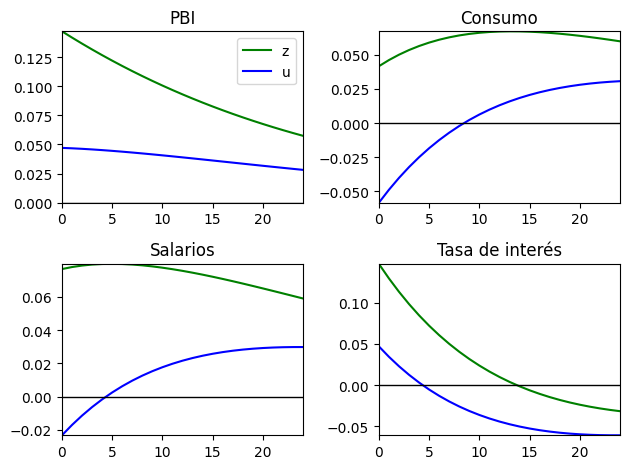

In [121]:
## ver el impulso respuesta
fig, axs = plt.subplots(2,2)
axs[0,0].plot(IRFy[0,:,0],'g')
axs[0,0].plot(IRFy[0,:,1],'b')
axs[0,0].axhline(0, color='k', lw=1)
axs[0,0].autoscale(enable=True, axis='both', tight=True)
axs[0,0].legend(['z', 'u'])
axs[0,0].set_title('PBI')

axs[0,1].plot(IRFy[1,:,0],'g')
axs[0,1].plot(IRFy[1,:,1],'b')
axs[0,1].axhline(0, color='k', lw=1)
axs[0,1].autoscale(enable=True, axis='both', tight=True)
axs[0,1].set_title('Consumo')

axs[1,0].plot(IRFy[4,:,0],'g')
axs[1,0].plot(IRFy[4,:,1],'b')
axs[1,0].axhline(0, color='k', lw=1)
axs[1,0].autoscale(enable=True, axis='both', tight=True)
axs[1,0].set_title('Salarios')

axs[1,1].plot(IRFy[5,:,0],'g')
axs[1,1].plot(IRFy[5,:,1],'b')
axs[1,1].axhline(0, color='k', lw=1)
axs[1,1].autoscale(enable=True, axis='both', tight=True)
axs[1,1].set_title('Tasa de interés')

plt.tight_layout()

## Conectando el modelo a los datos
Se estimará el modelo con los datos de PBI e inversión de USA. Estos se utilizan el logaritmos y en desvios de su tendencia [Hodrick y Prescott (1997)](https://www.jstor.org/stable/2953682?casa_token=sY4fLOkr5bEAAAAA%3AwqEcrVJeMfzWaVNxAjc96QrvhPjvWZGVAMdhVTRJ9O9PZjPlTGvVWsKN3x3r4FLUOpI1dZ-qiVDSenwUt8llbpJD4qG61yLqJXuVnXK9lGKHNG6M0B4-&seq=1#metadata_info_tab_contents):

In [122]:
## Carga los datos
start = dt.datetime(1984,1,1)
end   = dt.datetime(2011,12,31)
RGDP = np.log(web.DataReader('GDPC1', 'fred', start=start, end=end))
RINV = np.log(web.DataReader('GPDIC1', 'fred', start=start, end=end))
Data = pd.concat([ RGDP, RINV],axis=1)
Data.columns = ['RGDP', 'RINV']

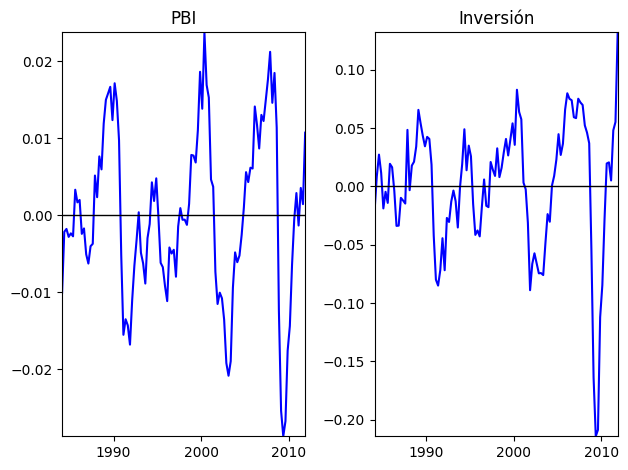

In [123]:
## Carga los datos
start = dt.datetime(1984,1,1)
end   = dt.datetime(2011,12,31)
RGDP = np.log(web.DataReader('GDPC1', 'fred', start=start, end=end))
RINV = np.log(web.DataReader('GPDIC1', 'fred', start=start, end=end))
Data = pd.concat([ RGDP, RINV],axis=1)
Data.columns = ['RGDP', 'RINV']
# Filtro HP
Ybar,gdp = HP(Data['RGDP'].to_numpy(),1600)
Ibar,inv = HP(Data['RINV'].to_numpy(),1600) ## No es recomendable,pero se quita la tendencia porque el modelo es estacionario .La data del modelo no es consistente
# Creando un DF
df = pd.DataFrame(data=np.c_[gdp,inv])
df.to_excel('datos.xlsx') # Para reproducir en dynare
# Dibujando la data
tlab = 1984+np.array(list(range(gdp.shape[0])))/4+0.125
fig, axs = plt.subplots(1,2)
axs[0].plot(tlab,gdp,'b')
axs[0].axhline(0, color='k', lw=1)
axs[0].autoscale(enable=True, axis='both', tight=True)
axs[0].set_title('PBI')
axs[1].plot(tlab,inv,'b')
axs[1].axhline(0, color='k', lw=1)
axs[1].autoscale(enable=True, axis='both', tight=True)
axs[1].set_title('Inversión')
plt.tight_layout()

### Representación de estado espacio
Según se ha mostrado, la solución del SLER tiene la forma
$$\mathbf{y}_{t} = \mathbf{g}_{1x}\mathbf{x}_{1t}+\mathbf{g}_{2x}\boldsymbol{\Lambda}\mathbf{x}_{2t-1}+\mathbf{g}_{2x}\tilde{\boldsymbol{\eta}}\boldsymbol{\varepsilon}_{t}$$
$$\mathbf{x}_{1t+1} = \mathbf{h}_{1x}\mathbf{x}_{1t} + \mathbf{h}_{2x}\boldsymbol{\Lambda}\mathbf{x}_{2t-1}+\mathbf{h}_{2x}\tilde{\boldsymbol{\eta}}\boldsymbol{\varepsilon}_{t}$$
$$\mathbf{x}_{2t} = \boldsymbol{\Lambda}\mathbf{x}_{2t-1}+\tilde{\boldsymbol{\eta}}\boldsymbol{\varepsilon}_{t}$$

definamos a las variables de estado de la REE como $\boldsymbol{\alpha}_t=[\mathbf{y}_{t}',\ \mathbf{x}_{1t+1}',\ \mathbf{x}_{2t}]'$. Noté que estos estados son de otro tipo (en contraste con los estados que se definieron al categorizar las variables del DSGE). Por lo tanto, el sistema de arriba se puede ecribir como la **ecuación de estados**:
$$\begin{bmatrix}
\mathbf{y}_{t}\\
\mathbf{x}_{1t+1}\\
\mathbf{x}_{2t}
\end{bmatrix}= \begin{bmatrix}
\mathbf{0} & \mathbf{g}_{1x} & \mathbf{g}_{2x}\boldsymbol{\Lambda}\\
\mathbf{0} & \mathbf{h}_{1x} & \mathbf{h}_{2x}\boldsymbol{\Lambda}\\
\mathbf{0} & \mathbf{0} & \boldsymbol{\Lambda}
\end{bmatrix}\begin{bmatrix}
\mathbf{y}_{t-1}\\
\mathbf{x}_{1t}\\
\mathbf{x}_{2t-1}
\end{bmatrix}+\begin{bmatrix}
\mathbf{g}_{2x}\\
\mathbf{h}_{2x}\\
\mathbf{I}
\end{bmatrix}\tilde{\boldsymbol{\eta}}\boldsymbol{\varepsilon}_{t}$$

Por su parte la **ecuación de medida** es
$$gdp_t=y_t+\nu_t^{y}$$
$$inv_t=i_t+\nu_t^{i}$$

Así, las varaibles en la REE son
* $\mathbf{Y}_t=[gdp_t,\ inv_t]$
* $\boldsymbol{\alpha}_t=[\mathbf{y}_t',\ \mathbf{x}_{1t+1}',\ \mathbf{x}_{2t}']=[y_t,\ c_t,\ i_t,\ h_t,\ w_t,\ r_t,\ k_t,\ u_t,\ z_t]'$


Recordemos que en las notas de clase, trabajamos con la siguiente notación para la REE:
$$\mathbf{Y}_t=\mathbf{Z}\boldsymbol{\alpha}_t+\mathbf{Bx}_t+\boldsymbol{\varepsilon}_t\text{ con }\boldsymbol{\varepsilon}_t\sim\mathcal{N}(\mathbf{0},\mathbf{H})$$
$$\boldsymbol{\alpha}_t = \mathbf{c} + \mathbf{T}\boldsymbol{\alpha}_{t-1}+\mathbf{R}\boldsymbol{\eta}_t\text{ con }\boldsymbol{\eta}_t\sim\mathcal{N}(\mathbf{0},\mathbf{Q})$$

Por lo tanto,
$$\mathbf{Z}=\begin{bmatrix}1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
                            0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\
\end{bmatrix},\ \mathbf{B}=\mathbf{0},\ \mathbf{H}=\begin{bmatrix}\sigma_{\nu,y}^2 & 0 \\
                            0 & \sigma_{\nu,i}^2\\
\end{bmatrix}$$
$$\mathbf{c}=\mathbf{0},\ \mathbf{T}=\begin{bmatrix}
\mathbf{0} & \mathbf{g}_{1x} & \mathbf{g}_{2x}\boldsymbol{\Lambda}\\
\mathbf{0} & \mathbf{h}_{1x} & \mathbf{h}_{2x}\boldsymbol{\Lambda}\\
\mathbf{0} & \mathbf{0} & \boldsymbol{\Lambda}
\end{bmatrix},\ \mathbf{R}=\begin{bmatrix}
\mathbf{g}_{2x}\\
\mathbf{h}_{2x}\\
\mathbf{I}
\end{bmatrix}\tilde{\boldsymbol{\eta}}\text{ y }\mathbf{Q}=\mathbf{I}$$

> **Un DSGE es un VAR**: Del resumen de arriba se tiene que (ignorando $\mathbf{x}_t$ y $\boldsymbol{\varepsilon}_t$):
$$\mathbf{Y}_t=\mathbf{Z}\boldsymbol{\alpha}_t+\mathbf{B}$$
$$\boldsymbol{\alpha}_t = \mathbf{c} + \mathbf{T}\boldsymbol{\alpha}_{t-1}+\mathbf{R}\boldsymbol{\eta}_t\text{ con }\boldsymbol{\eta}_t\sim\mathcal{N}(\mathbf{0},\mathbf{Q})$$
Note que utilizando el operador de rezagos (i.e., $LM_t=M_{t-1}$), la ecuación de transición se puede escribir de la siguiente manera:
$$\boldsymbol{\alpha}_t = (\mathbf{I}-\mathbf{T})^{-1}\mathbf{c} +(\mathbf{I}-\mathbf{T}L)^{-1}\mathbf{R}\boldsymbol{\eta}_t\text{ con }\boldsymbol{\eta}_t\sim\mathcal{N}(\mathbf{0},\mathbf{Q})$$
reemplazando esto en la ecuación de medida
$$\mathbf{Y}_t=\mathbf{B}+\mathbf{Z}(\mathbf{I}-\mathbf{T})^{-1}\mathbf{c} +\mathbf{Z}(\mathbf{I}-\mathbf{T}L)^{-1}\mathbf{R}\boldsymbol{\eta}_t\text{ con }\boldsymbol{\eta}_t\sim\mathcal{N}(\mathbf{0},\mathbf{Q})$$
Por lo tanto
$$\mathbf{Y}_t=\Phi(L)\boldsymbol{\eta}_t$$
que es la forma general de un VAR($\infty$).

**Determinación del punto inicial**: Esperanza incondicional
$$\boldsymbol{\alpha}_{0|0}=\mathrm{E}\boldsymbol{\alpha}_t:\quad\boldsymbol{\alpha}_{0|0} = (\mathbf{I}-\mathbf{T})^{-1}\mathbf{c}=\mathbf{0}$$
$$\boldsymbol{\Sigma}^{\alpha}_{0|0}=\mathrm{E}\boldsymbol{\alpha}_t\boldsymbol{\alpha}_t':\quad\boldsymbol{\Sigma}^{\alpha}_{0|0} - \mathbf{T}\boldsymbol{\Sigma}^{\alpha}_{0|0}\mathbf{T}'-\mathbf{R}\mathbf{Q}\mathbf{R}'=\mathbf{0}$$
la ultima ecuación es la ecuación de Lyapunov que se resuelve con la función ``solve_discrete_lyapunov`` del módulo ``scipy``. El $\boldsymbol{\Sigma}^{\alpha}_{0|0}$ debería ser una matriz definida positiva. En caso no resulte así, se puede calcular su matriz definida positiva más cercana con la norma de Frobenius (implementada en la función ``nearestSPD`` del módulo ``DSGEstuff.py``).

El sistema de estados está automatizado en la función ``get_StatesMat`` del módulo ``DSGEstuff.py``. Por su parte, el sistema de medidas se especifica a continuación

In [124]:
def GenMeasureMat(solvedmodel,measureerror2): ##Define una función para devolver las que necesitamos de la ecuacion de medida
    n = solvedmodel['SLER']['dimensiones']['n'] ## solo deberiamos cambiar la medida (para lo que tenemos datos)

    Z = np.zeros(shape=(2,n))
    Z[0,0] = 1
    Z[1,2] = 1

    H = np.zeros(shape=(2,2))
    H[0,0] = measureerror2[0].item()
    H[1,1] = measureerror2[1].item()

    solvedmodel['REE']['Z']=Z
    solvedmodel['REE']['H']=H

    return solvedmodel

Calibramos la desviación estándar de los errores de medida como el 10% de la variación de los datos

In [125]:
MEsdgdp = np.std(gdp)*0.1
MEsdinv = np.std(inv)*0.1

In [126]:
modelo = DG.get_StatesMat(modelo,True)
modelo = GenMeasureMat(modelo,np.array([[MEsdgdp**2],[MEsdinv**2]]))

In [127]:
DG.printREE(modelo['REE']) ## devuelve las matrices

---- Matriz de transición T:
0  0  0  0  0  0  0.162828  1.39737  0.44737
0  0  0  0  0  0  0.537093  0.395795  -0.554205
0  0  0  0  0  0  -1.05528  4.65717  3.70717
0  0  0  0  0  0  -0.24951  0.667717  0.667717
0  0  0  0  0  0  0.412338  0.729653  -0.220347
0  0  0  0  0  0  -0.837172  1.39737  0.44737
0  0  0  0  0  0  0.948618  0.116429  0.116429
0  0  0  0  0  0  0  0.95  0
0  0  0  0  0  0  0  0  0.95
---- Matriz R:
0.147092  0.0470916
0.0416626  -0.0583374
0.490228  0.390228
0.070286  0.070286
0.0768056  -0.0231944
0.147092  0.0470916
0.0122557  0.0122557
0.1  0
0  0.1
---- Matriz de carga Z:
1  0  0  0  0  0  0  0  0
0  0  1  0  0  0  0  0  0
---- Matriz varianza H:
1.17918e-06  0
0  3.1432e-05


Utilizando el filtro de Kalman en la REE

In [128]:
data = np.c_[gdp,inv]
ops = {'compute_stderrors':False,'a_initial':modelo['REE']['alpha0'].flatten(),'P_initial':modelo['REE']['Sigma_a0']}
mod_filtered = KF.KFplus(data,modelo['REE'],ops)

In [129]:
modelo['REE']

{'c': array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]),
 'T': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.16282831,  1.39737036,  0.44737036],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.53709329,  0.39579493, -0.55420507],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        , -1.05527989,  4.65716577,  3.70716577],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        , -0.24950998,  0.66771696,  0.66771696],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.41233829,  0.7296534 , -0.2203466 ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        , -0.83717169,  1.39737036,  0.44737036],
        [ 0.        ,  0.        ,  0.        

In [130]:
mod_filtered['a_s'].shape

(112, 9)

In [131]:
a_s=mod_filtered['a_s']
a_u=mod_filtered['a_u']
a_p=mod_filtered['a_p'][1:,:]

**Problemas con el smoothed**: producto de que el modelo no es estimado

In [132]:
mat2show = pd.DataFrame(np.c_[a_p[:,0],a_u[:,0],a_s[:,0],gdp],
                        columns = ['y(t|t-1)','y(t|t)','y(t|T)','gdp(t)'],
                        index = list(range(112)))
mat2show

,y(t|t-1),y(t|t),y(t|T),gdp(t)
0,-0.009657,-0.010024,-0.010024,-0.010024
1,-0.002024,-0.002122,-0.002124,-0.002122
2,-0.001583,-0.001748,-0.001747,-0.001749
3,-0.002632,-0.002783,-0.002781,-0.002782
4,-0.002334,-0.002327,-0.002328,-0.002324
...,...,...,...,...
107,0.002796,0.002908,0.002908,0.002909
108,-0.001269,-0.001306,-0.001308,-0.001306
109,0.003587,0.003574,0.003572,0.003572
110,0.001653,0.001471,0.001468,0.001469


Dibujando algunos estados

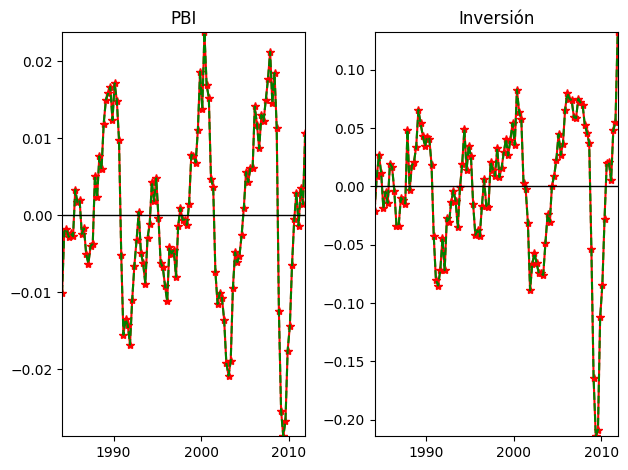

In [133]:
mat2plot = a_u ## Grafica y es recomendable tener errores de medida con varianza calibrada
tlab = 1984+np.array(list(range(gdp.shape[0])))/4+0.125
fig, axs = plt.subplots(1,2)
nb = 0
axs[0].plot(tlab[nb:],gdp[nb:],'-*r')
axs[0].plot(tlab[nb:],mat2plot[nb:,0],'--g')
axs[0].axhline(0, color='k', lw=1)
axs[0].autoscale(enable=True, axis='both', tight=True)
axs[0].set_title('PBI')

axs[1].plot(tlab[nb:],inv[nb:],'-*r')
axs[1].plot(tlab[nb:],mat2plot[nb:,2],'--g')
axs[1].axhline(0, color='k', lw=1)
axs[1].autoscale(enable=True, axis='both', tight=True)
axs[1].set_title('Inversión')

plt.tight_layout()

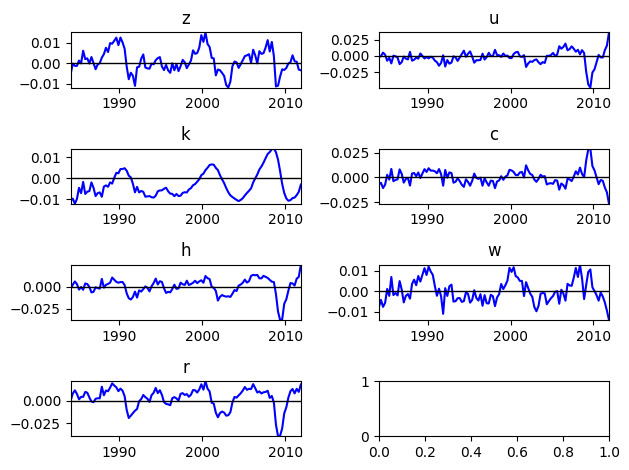

In [134]:
fig, axs = plt.subplots(4,2) ## Latente
nb = 0
axs[0,0].plot(tlab[nb:],mat2plot[nb:,7],'b')
axs[0,0].axhline(0, color='k', lw=1)
axs[0,0].autoscale(enable=True, axis='both', tight=True)
axs[0,0].set_title('z')

axs[0,1].plot(tlab[nb:],mat2plot[nb:,8],'b')
axs[0,1].axhline(0, color='k', lw=1)
axs[0,1].autoscale(enable=True, axis='both', tight=True)
axs[0,1].set_title('u')

axs[1,0].plot(tlab[nb:],mat2plot[nb:,6],'b')
axs[1,0].axhline(0, color='k', lw=1)
axs[1,0].autoscale(enable=True, axis='both', tight=True)
axs[1,0].set_title('k')

axs[1,1].plot(tlab[nb:],mat2plot[nb:,1],'b')
axs[1,1].axhline(0, color='k', lw=1)
axs[1,1].autoscale(enable=True, axis='both', tight=True)
axs[1,1].set_title('c')

axs[2,0].plot(tlab[nb:],mat2plot[nb:,3],'b')
axs[2,0].axhline(0, color='k', lw=1)
axs[2,0].autoscale(enable=True, axis='both', tight=True)
axs[2,0].set_title('h')

axs[2,1].plot(tlab[nb:],mat2plot[nb:,4],'b')
axs[2,1].axhline(0, color='k', lw=1)
axs[2,1].autoscale(enable=True, axis='both', tight=True)
axs[2,1].set_title('w')

axs[3,0].plot(tlab[nb:],mat2plot[nb:,5],'b')
axs[3,0].axhline(0, color='k', lw=1)
axs[3,0].autoscale(enable=True, axis='both', tight=True)
axs[3,0].set_title('r')



plt.tight_layout()

In [135]:
mod_filtered['minuslogL']#verosilimitud

-3.1843040810544814

### Estimación
Se desa estimar $\alpha$, $\beta$, $\delta$, $\eta$, $\rho_z$, $\rho_u$, $\sigma_z$, $\sigma_u$.

$$\beta=\frac{1}{1+\frac{tasa\_imp}{100}}$$

Considere el prior: $\alpha\sim\beta(0.33,0.05)$, $100(\beta^{-1}-1)\sim\gamma^{-1}(1,0.10)$, $\delta\sim\beta(0.03,0.01)$, $\eta\sim\gamma^{-1}(0.50,0.50)$, $\rho_z\sim\beta(0.60,0.20)$, $\rho_u\sim\beta(0.60,0.20)$, $100\sigma_z\sim\gamma^{-1}(2,2)$, $100\sigma_u\sim\gamma^{-1}(2,2)$

La función que computa el prior es:

In [136]:
PRIORmean = np.array([0.33,  #ALPHA
                      1.00,  #tBETA
                      0.03,  #DELTA
                      0.50,  #ETA
                      0.60,  #RHOz
                      0.60,  #RHOu
                      2.00,  #tSIGMAz
                      2.00]) #tSIGMAu
PRIORvar = np.array([0.20,  #ALPHA
                     1.00,  #tBETA
                     0.015, #DELTA
                     0.50,  #ETA
                     0.20,  #RHOz
                     0.20,  #RHOu
                     2.00,  #tSIGMAz
                     2.00]) #tSIGMAu
def get_minuslogprior(theta):
    from math import log
    # unpack theta
    ALPHA   = theta[0]
    tBETA   = theta[1]
    DELTA   = theta[2]
    ETA     = theta[3]
    RHOz    = theta[4]
    RHOu    = theta[5]
    SIGMAz100  = theta[6]
    SIGMAu100  = theta[7]
    # compute pdf
    pALPHA = DG.BetaPDF(ALPHA,PRIORmean[0],PRIORvar[0])
    ptBETA = DG.InvGammaPDF(tBETA,PRIORmean[1],PRIORvar[1])
    pDELTA = DG.BetaPDF(DELTA,PRIORmean[2],PRIORvar[2])
    pETA = DG.InvGammaPDF(ETA,PRIORmean[3],PRIORvar[3])
    pRHOz = DG.BetaPDF(RHOz,PRIORmean[4],PRIORvar[4])
    pRHOu = DG.BetaPDF(RHOu,PRIORmean[5],PRIORvar[5])
    pSIGMAz100 = DG.InvGammaPDF(SIGMAz100,PRIORmean[6],PRIORvar[6])
    pSIGMAu100 = DG.InvGammaPDF(SIGMAu100,PRIORmean[7],PRIORvar[7])
    ## Evaluar los beta evaluados en  los puntos
    # Joint
    pALL = pALPHA*pETA*pRHOz*pRHOu*pSIGMAz100*pSIGMAu100*pDELTA*ptBETA
    eps = np.finfo(float).eps
    if pALL <= eps:
        pALL = np.finfo(float).eps

    return -log( pALL )

##Uso el prior



#### Verosimilitud

1. Necesitamos una función que especifique el modelo en función a los parámetros que se estimarán

In [137]:
def SLERfun(theta):
    # unpack theta
    ALPHA   = theta[0].item()
    BETA    = 1/(1+theta[1].item()/100)
    DELTA   = theta[2].item()
    ETA     = theta[3].item()
    RHOz    = theta[4].item()
    RHOu    = theta[5].item()
    SIGMAz  = theta[6].item()/100
    SIGMAu  = theta[7].item()/100
    # Parametros estimado
    # Ninguno

    # pack params
    param = np.ndarray(shape=(8,1))
    param[0] = ALPHA
    param[1] = BETA
    param[2] = DELTA
    param[3] = ETA
    param[4] = RHOz
    param[5] = RHOu
    param[6] = SIGMAz
    param[7] = SIGMAu
    return RBCveranoBCRP(param) #te devuelve las mtrices que caracterizan el estado espacio

2. Se necesita también una función que especifique el sistema de medidas en función a los coeficientes a estimar y al SLER

In [138]:
def Measurefun(modelo): return GenMeasureMat(modelo,np.array([[MEsdgdp**2],[MEsdinv**2]])) #Modelo matriz Dsge. El getmeasure crea las matrices

3. Punto inicial: calibración

In [139]:
theta_0=np.ndarray(shape=(8,1))
theta_0[0] = ALPHA_0
theta_0[1] = 100*(1/BETA_0-1)
theta_0[2] = DELTA_0
theta_0[3] = ETA_0
theta_0[4] = RHOz_0
theta_0[5] = RHOu_0
theta_0[6] = SIGMAz_0*100
theta_0[7] = SIGMAu_0*100
theta_0

#generamos la matriz de medida

array([[ 0.33      ],
       [ 1.01010101],
       [ 0.025     ],
       [ 0.5       ],
       [ 0.95      ],
       [ 0.95      ],
       [10.        ],
       [10.        ]])

<ipython-input-136-38af6d548a8c>:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return -log( pALL )


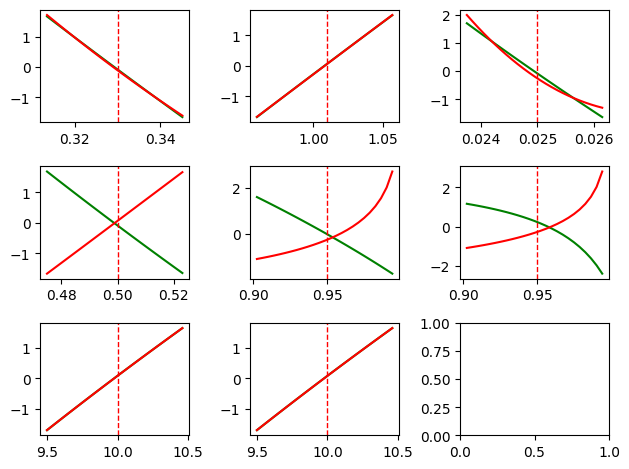

In [140]:
x0 = theta_0
xup = x0*1.05
xdw = x0*0.95
def minusllk(theta,data): return DG.get_minusloglike(theta,data,SLERfun,Measurefun)
def minuslps(theta,data): return DG.get_minuslogpost(theta,data,SLERfun,Measurefun,get_minuslogprior)
others = {'fcn1':minuslps}
KF.modecheck(minusllk, x0, xup, xdw, data, others)

In [141]:
MinPos = 1e-6
bnds = ((MinPos, 1-MinPos),     # ALPHA
        (MinPos, None),         # BETA
        (MinPos, 1-MinPos),     # DELTA
        (MinPos,None),          # ETA
        (MinPos,1-MinPos),      # RHOz
        (MinPos,1-MinPos),      # RHOu
        (MinPos,None),          # SIGMAz
        (MinPos,None))          # SIGMAu
res = minimize(DG.get_minuslogpost, theta_0.flatten(), args=(data,SLERfun,Measurefun,get_minuslogprior), method='L-BFGS-B', options={'disp': True},bounds=bnds)

#restricciones a los parametros

In [142]:
res.success

True

Resultados del cáculo de la moda

In [143]:
row_coefs = np.array(['ALPHA','100(1/BETA-1)','DELTA','ETA','RHOz','RHOu','100xSIGMAz','100xSIGMAu'])
col_names = np.array(['x0','xopt: moda','sd(xopt)'])
starting = theta_0
postmode = res.x
hess_inv = res.hess_inv.todense()
postmodesd = np.diag(np.linalg.cholesky(hess_inv))

mat2show = pd.DataFrame(starting, columns = [col_names[0]], index = row_coefs)
mat2show[col_names[1]]=postmode
mat2show[col_names[2]]=postmodesd

mat2show

## ver moda

,x0,xopt: moda,sd(xopt)
ALPHA,0.330000,0.339761,1.204253
100(1/BETA-1),1.010101,0.499821,1.029729
DELTA,0.025000,0.023305,0.015210
ETA,0.500000,0.263298,0.263004
RHOz,0.950000,0.669975,0.637406
RHOu,0.950000,0.680390,0.517811
100xSIGMAz,10.000000,0.841905,0.440720
100xSIGMAu,10.000000,0.927648,0.490856


Verificando la convergencia

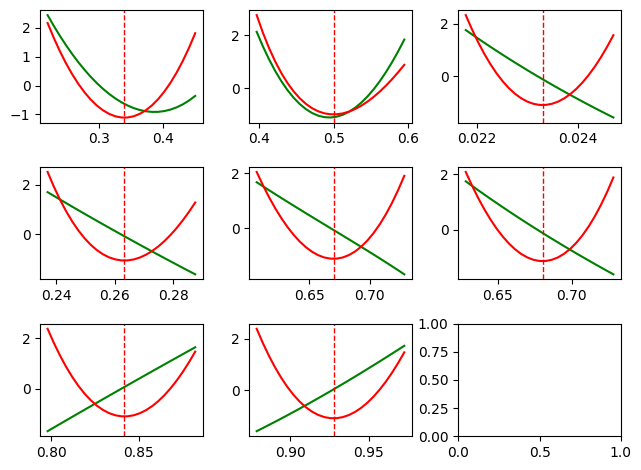

In [144]:
x0 = res.x
hess_inv = res.hess_inv.todense()
scale = 0.1
sds = np.diag(np.linalg.cholesky(hess_inv))
xup = x0+scale*sds
xdw = x0-scale*sds
KF.modecheck(minusllk, x0, xup, xdw, data, others)

Filtrando el modelo en la moda

In [145]:
modelohat = dict()
modelohat['SLER'] = SLERfun(res.x) # Nos devuelve los matricez
modelohat = DG.SolveDSGE(modelohat)
modelohat = DG.get_StatesMat(modelohat,True)
modelohat = GenMeasureMat(modelohat,np.array([[0.001**2],[0.006**2]])*0)
ops = {'compute_stderrors':False,'a_initial':modelohat['REE']['alpha0'].flatten(),'P_initial':modelohat['REE']['Sigma_a0']}
mod_filthat = KF.KFplus(data,modelohat['REE'],ops)
#Esto estimo el DSGE en el punto de mmoda

In [146]:
a_u=mod_filthat['a_u']

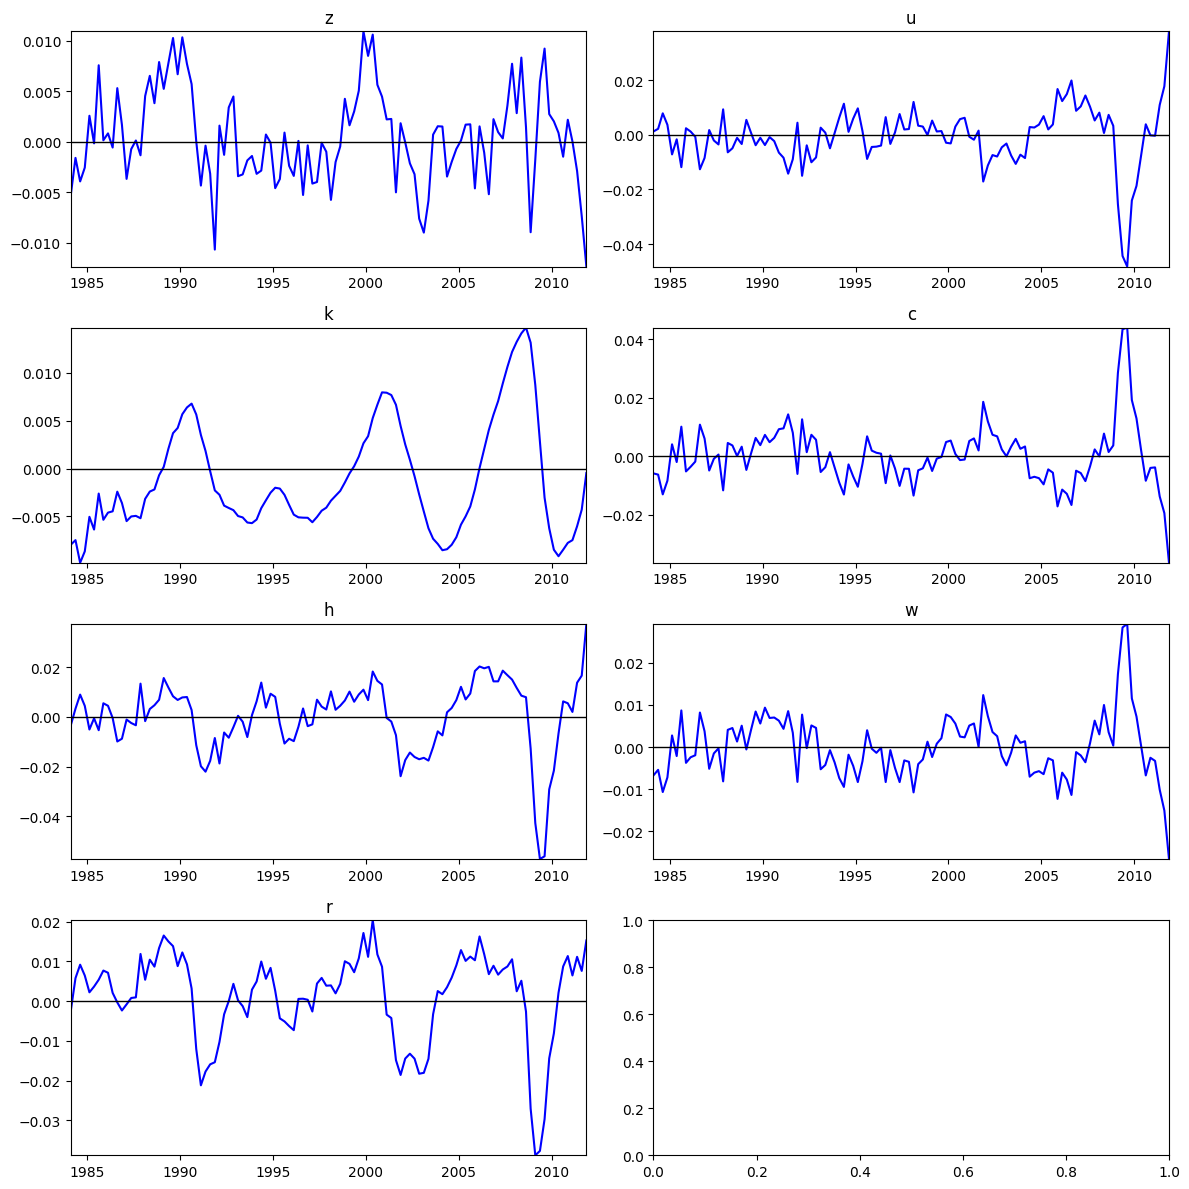

In [147]:
tlab = 1984+np.array(list(range(gdp.shape[0])))/4+0.125
fig, axs = plt.subplots(4,2,figsize=(12,12))
nb = 0
axs[0,0].plot(tlab[nb:],a_u[nb:,7],'b')
axs[0,0].axhline(0, color='k', lw=1)
axs[0,0].autoscale(enable=True, axis='both', tight=True)
axs[0,0].set_title('z')

axs[0,1].plot(tlab[nb:],a_u[nb:,8],'b')
axs[0,1].axhline(0, color='k', lw=1)
axs[0,1].autoscale(enable=True, axis='both', tight=True)
axs[0,1].set_title('u')

axs[1,0].plot(tlab[nb:],a_u[nb:,6],'b')
axs[1,0].axhline(0, color='k', lw=1)
axs[1,0].autoscale(enable=True, axis='both', tight=True)
axs[1,0].set_title('k')

axs[1,1].plot(tlab[nb:],a_u[nb:,1],'b')
axs[1,1].axhline(0, color='k', lw=1)
axs[1,1].autoscale(enable=True, axis='both', tight=True)
axs[1,1].set_title('c')

axs[2,0].plot(tlab[nb:],a_u[nb:,3],'b')
axs[2,0].axhline(0, color='k', lw=1)
axs[2,0].autoscale(enable=True, axis='both', tight=True)
axs[2,0].set_title('h')

axs[2,1].plot(tlab[nb:],a_u[nb:,4],'b')
axs[2,1].axhline(0, color='k', lw=1)
axs[2,1].autoscale(enable=True, axis='both', tight=True)
axs[2,1].set_title('w')

axs[3,0].plot(tlab[nb:],a_u[nb:,5],'b')
axs[3,0].axhline(0, color='k', lw=1)
axs[3,0].autoscale(enable=True, axis='both', tight=True)
axs[3,0].set_title('r')



plt.tight_layout()

### Metropolis-Hasting

In [148]:
b=100
n=10000
x0 = res.x
LTOmega = np.linalg.cholesky(hess_inv)
scale = 0.15
xsim, a, smooth_sim, updated_sim, predicted_sim = DG.get_MHdraws(n, b, SLERfun,Measurefun,get_minuslogprior, x0, LTOmega, scale, data) ## esto saca el metropolis hasting.Line de codigo que calcula el DSGE en metropolis hasting


                                                  ]
-------------------------------------------------]


In [149]:
data.shape

(112, 2)

In [150]:
smooth_sim.shape

(112, 9, 10000)

In [151]:
xsim.shape

(8, 10000)

Resumen de estimación

In [152]:
row_coefs = np.array(['ALPHA','100(1/BETA-1)','DELTA','ETA','RHOz','RHOu','100xSIGMAz','100xSIGMAu'])
col_names = np.array(['PRIOR: shape','PRIOR: mean','PRIOR: var','POST: mode','POST: mean','POST: q5','POST: q95','ratio var'])
priorshape = np.array(['beta','gamma inv','beta','gamma inv','beta','beta','gamma inv','gamma inv'])
priormeansd = np.c_[PRIORmean,PRIORvar]
postmode = res.x
postmean = np.mean(xsim, axis=-1)
postq5 = np.percentile(xsim, 5, axis=-1)
postq95 = np.percentile(xsim, 95, axis=-1)
ratiovarianza = 100*np.var(xsim, axis=-1)/priormeansd[:,1]


mat2show = pd.DataFrame(priorshape, columns = [col_names[0]], index = row_coefs)
mat2show[col_names[1]]=priormeansd[:,0]
mat2show[col_names[2]]=priormeansd[:,1]
mat2show[col_names[3]]=postmode
mat2show[col_names[4]]=postmean
mat2show[col_names[5]]=postq5
mat2show[col_names[6]]=postq95
mat2show[col_names[7]]=ratiovarianza

mat2show

,PRIOR: shape,PRIOR: mean,PRIOR: var,POST: mode,POST: mean,POST: q5,POST: q95,ratio var
ALPHA,beta,0.33,0.200,0.339761,0.401765,0.123934,0.714939,16.511037
100(1/BETA-1),gamma inv,1.00,1.000,0.499821,0.661995,0.301620,1.263470,9.248135
DELTA,beta,0.03,0.015,0.023305,0.034013,0.011795,0.061098,1.476683
ETA,gamma inv,0.50,0.500,0.263298,0.438271,0.145048,0.920393,11.796998
RHOz,beta,0.60,0.200,0.669975,0.571098,0.232844,0.876961,19.335581
RHOu,beta,0.60,0.200,0.680390,0.630586,0.288897,0.892490,16.948592
100xSIGMAz,gamma inv,2.00,2.000,0.841905,1.186862,0.552884,2.266254,12.901626
100xSIGMAu,gamma inv,2.00,2.000,0.927648,1.620290,0.713585,3.206092,27.635500


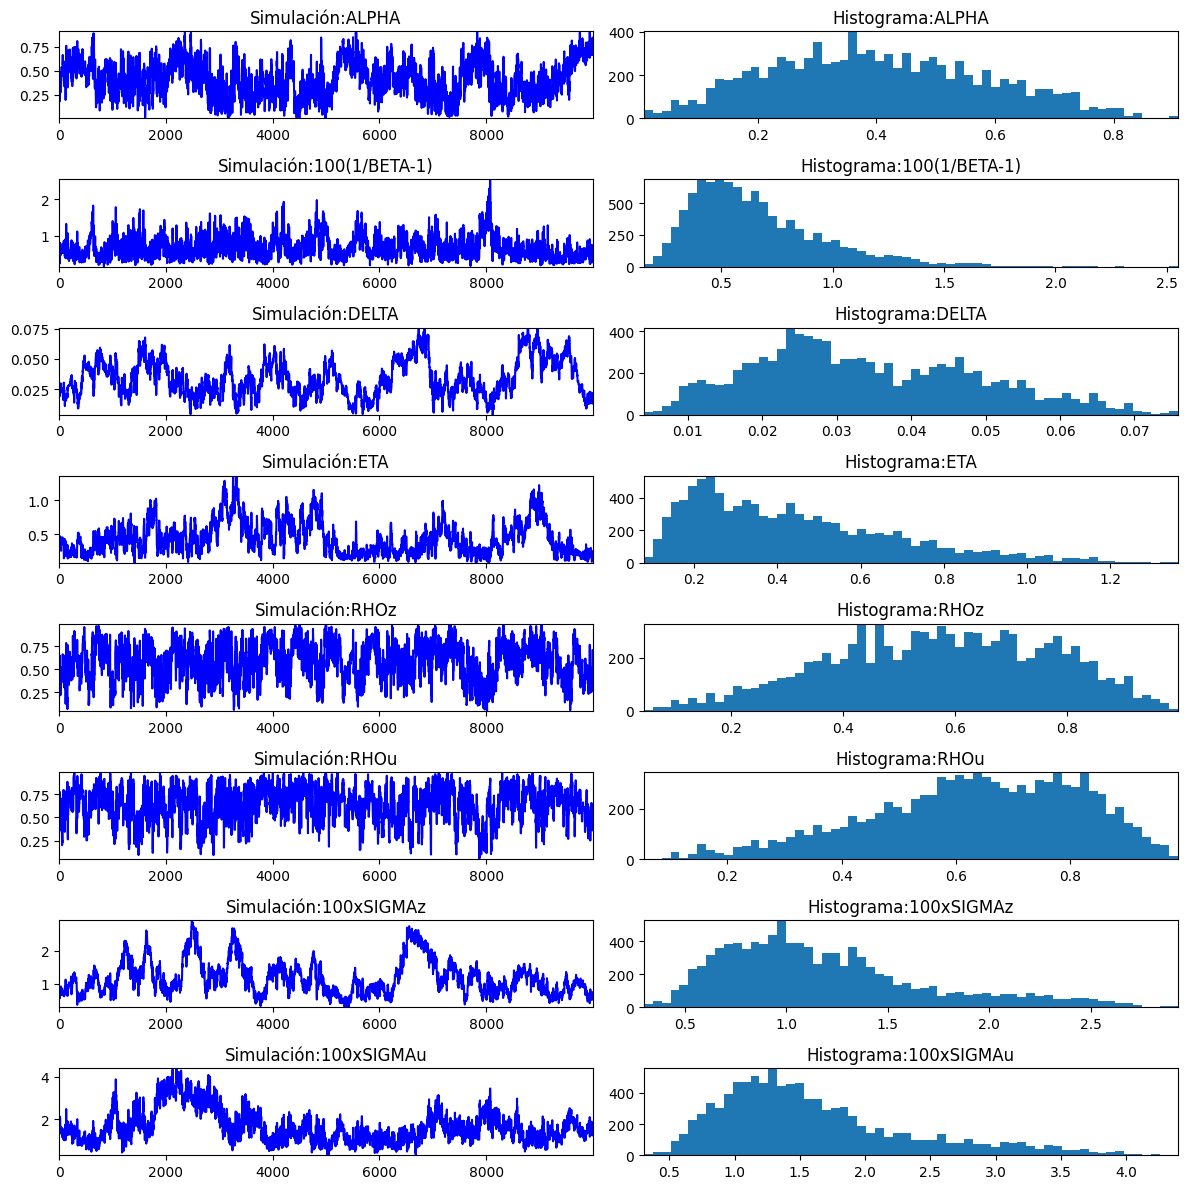

In [153]:
from math import floor
fig, axs = plt.subplots(8,2,figsize=(12,12))
for v in range(8):
    axs[v,0].plot(xsim[v,:],'b')
    axs[v,0].set_title('Simulación:'+row_coefs[v])
    axs[v,0].autoscale(enable=True, axis='both', tight=True)
    axs[v,1].hist(xsim[v,:],60)
    axs[v,1].set_title('Histograma:'+row_coefs[v])
    axs[v,1].autoscale(enable=True, axis='both', tight=True)

fig.tight_layout()

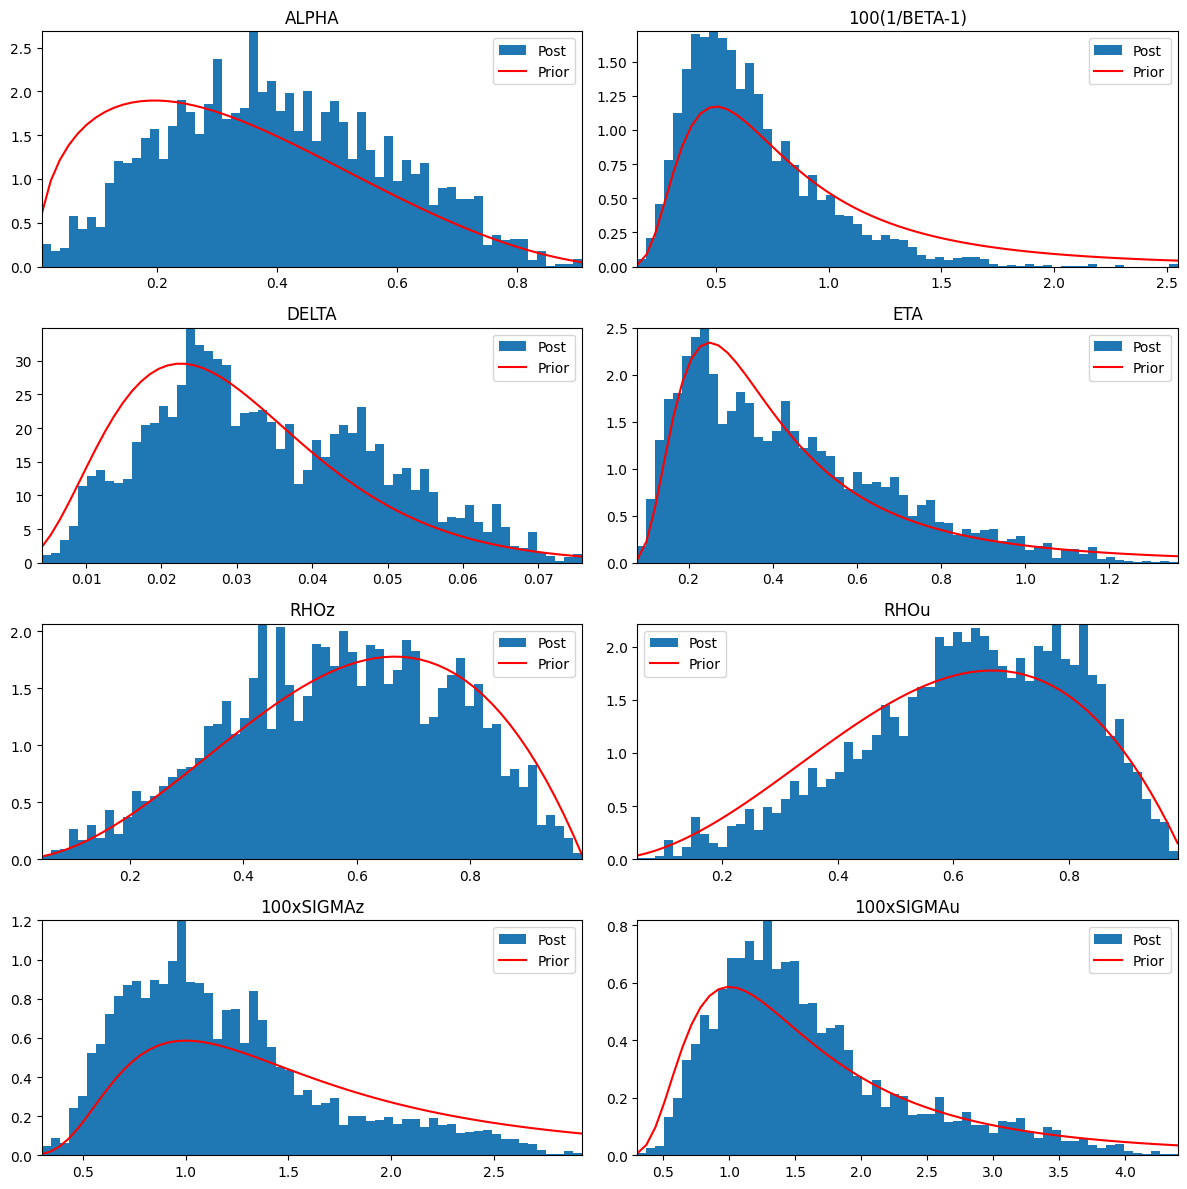

In [154]:
num_bins=60
fig, axs = plt.subplots(4,2,figsize=(12,12))
for v in range(8):
    n, bins, patches = axs[floor(v/2),v%2].hist(xsim[v,:], num_bins, density=1,label='Post')
    mu = priormeansd[v,0]
    sd = priormeansd[v,1]
    if v==0 or v==2 or v==4 or v==5:
        pdf = np.array([DG.BetaPDF(x,mu,sd) for x in bins])
    else:
        pdf = np.array([DG.InvGammaPDF(x,mu,sd) for x in bins])

    axs[floor(v/2),v%2].plot(bins, pdf,'r',label='Prior')
    axs[floor(v/2),v%2].set_title(row_coefs[v])
    axs[floor(v/2),v%2].autoscale(enable=True, axis='both', tight=True)
    axs[floor(v/2),v%2].legend()

fig.tight_layout()

Los estados resultantes se muestran a continuación

In [155]:
obj2show = updated_sim
obj_mean = np.mean(obj2show, axis=-1)
obj_Q5 = np.percentile(obj2show, 5, axis=-1)
obj_Q95 = np.percentile(obj2show, 95, axis=-1)

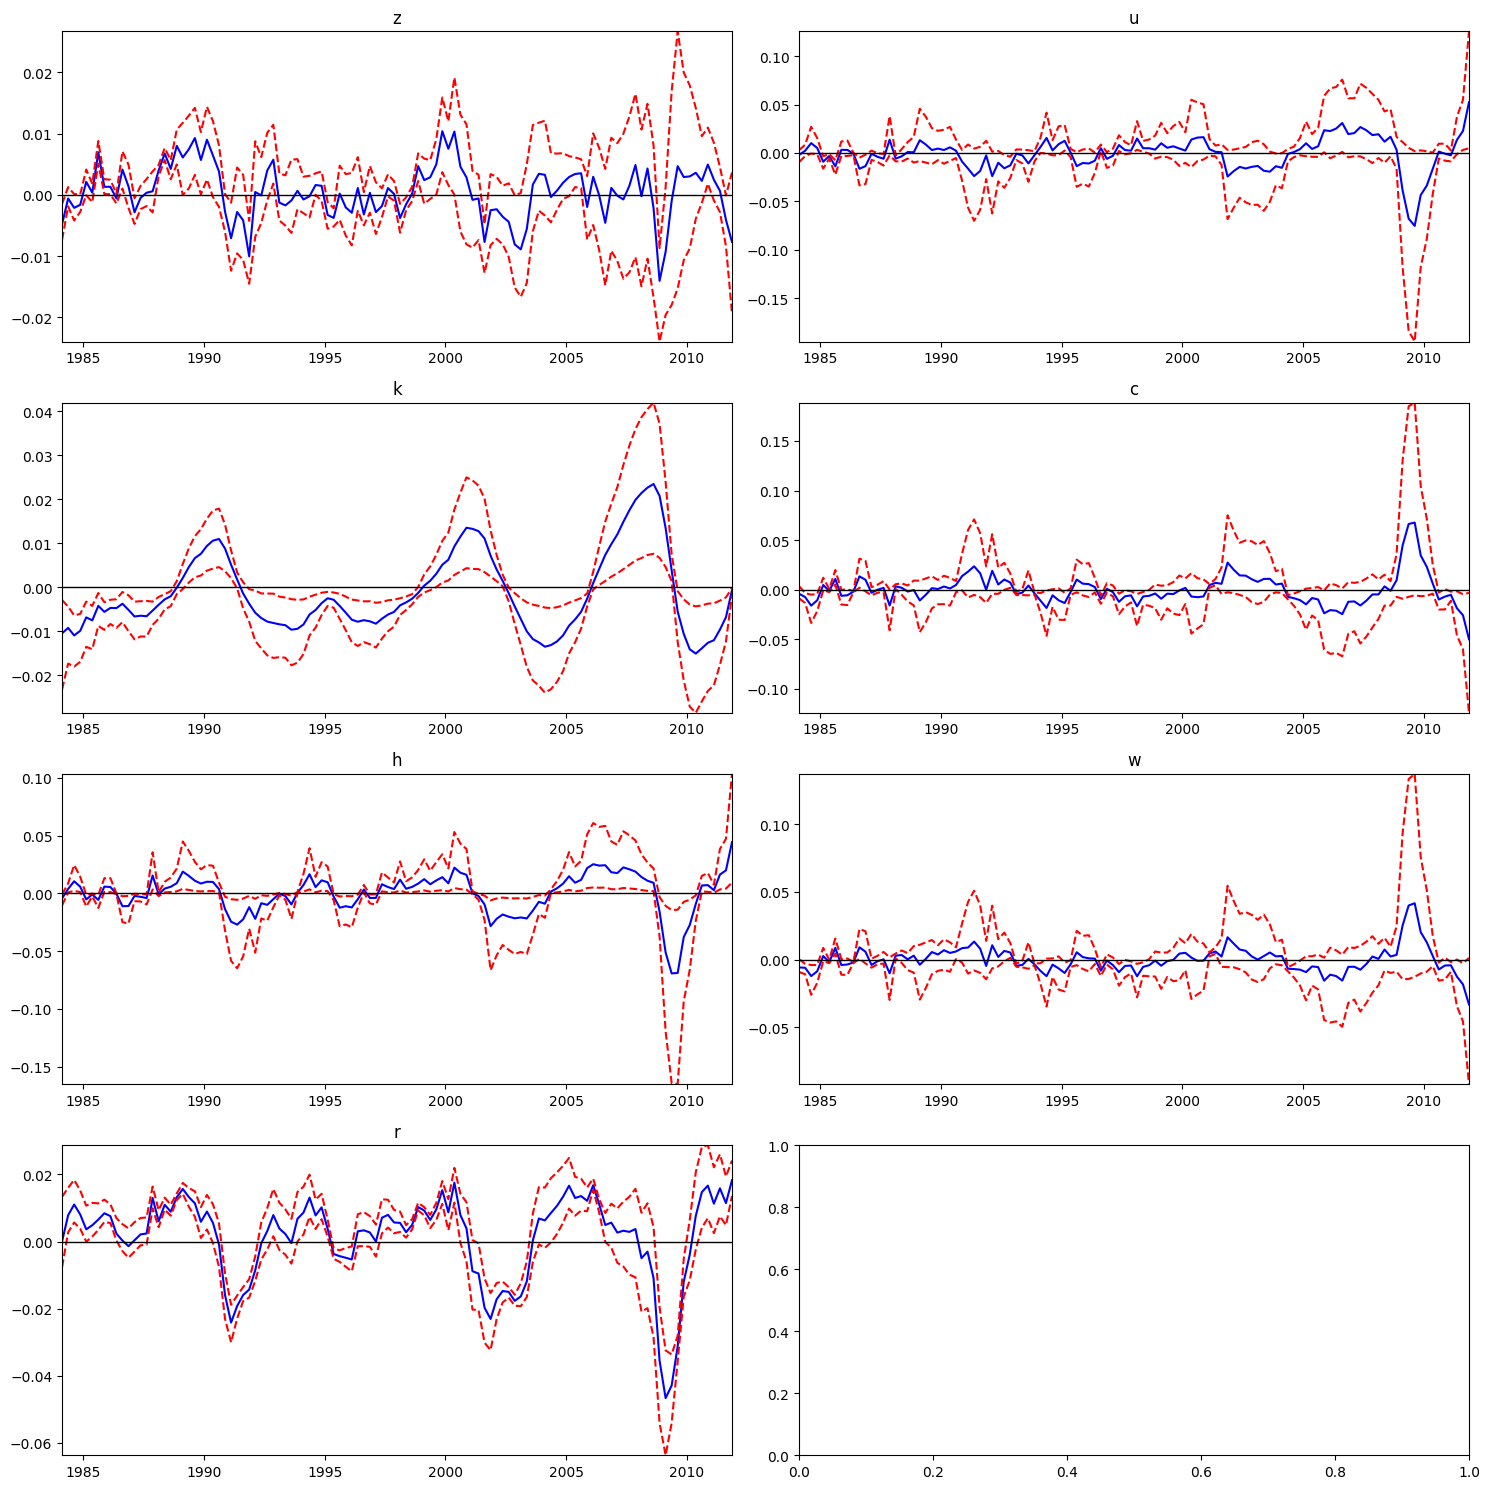

In [156]:
tlab = 1984+np.array(list(range(gdp.shape[0])))/4+0.125
fig, axs = plt.subplots(4,2,figsize=(15,15))
nb = 0
axs[0,0].plot(tlab[nb:],obj_mean[nb:,7],'b')
axs[0,0].plot(tlab[nb:],obj_Q5[nb:,7],'--r')
axs[0,0].plot(tlab[nb:],obj_Q95[nb:,7],'--r')
axs[0,0].axhline(0, color='k', lw=1)
axs[0,0].autoscale(enable=True, axis='both', tight=True)
axs[0,0].set_title('z')

axs[0,1].plot(tlab[nb:],obj_mean[nb:,8],'b')
axs[0,1].plot(tlab[nb:],obj_Q5[nb:,8],'--r')
axs[0,1].plot(tlab[nb:],obj_Q95[nb:,8],'--r')
axs[0,1].axhline(0, color='k', lw=1)
axs[0,1].autoscale(enable=True, axis='both', tight=True)
axs[0,1].set_title('u')

axs[1,0].plot(tlab[nb:],obj_mean[nb:,6],'b')
axs[1,0].plot(tlab[nb:],obj_Q5[nb:,6],'--r')
axs[1,0].plot(tlab[nb:],obj_Q95[nb:,6],'--r')
axs[1,0].axhline(0, color='k', lw=1)
axs[1,0].autoscale(enable=True, axis='both', tight=True)
axs[1,0].set_title('k')

axs[1,1].plot(tlab[nb:],obj_mean[nb:,1],'b')
axs[1,1].plot(tlab[nb:],obj_Q5[nb:,1],'--r')
axs[1,1].plot(tlab[nb:],obj_Q95[nb:,1],'--r')
axs[1,1].axhline(0, color='k', lw=1)
axs[1,1].autoscale(enable=True, axis='both', tight=True)
axs[1,1].set_title('c')

axs[2,0].plot(tlab[nb:],obj_mean[nb:,3],'b')
axs[2,0].plot(tlab[nb:],obj_Q5[nb:,3],'--r')
axs[2,0].plot(tlab[nb:],obj_Q95[nb:,3],'--r')
axs[2,0].axhline(0, color='k', lw=1)
axs[2,0].autoscale(enable=True, axis='both', tight=True)
axs[2,0].set_title('h')

axs[2,1].plot(tlab[nb:],obj_mean[nb:,4],'b')
axs[2,1].plot(tlab[nb:],obj_Q5[nb:,4],'--r')
axs[2,1].plot(tlab[nb:],obj_Q95[nb:,4],'--r')
axs[2,1].axhline(0, color='k', lw=1)
axs[2,1].autoscale(enable=True, axis='both', tight=True)
axs[2,1].set_title('w')

axs[3,0].plot(tlab[nb:],obj_mean[nb:,5],'b')
axs[3,0].plot(tlab[nb:],obj_Q5[nb:,5],'--r')
axs[3,0].plot(tlab[nb:],obj_Q95[nb:,5],'--r')
axs[3,0].axhline(0, color='k', lw=1)
axs[3,0].autoscale(enable=True, axis='both', tight=True)
axs[3,0].set_title('r')

plt.tight_layout()

# Comparar modelos
* En este modelo, se incluyeron dos choques (productividad y eficiencia de la inversión). Podría haber otro choque relevante (por ejemplo, choque de preferencias)
* La estructura fundamental del modelo podría ser diferente
* Lo ideal sería contar con varios modelos estimados, y comparar sus cualidades

## Probabilidad posterior entre modelos
La probabilidad posterior de un conjunto de modelos se calcula con promedios bayesianos
$$\pi_{i}=\frac{\pi_{i,0}p(y|M_i)}{\sum_{j=1}^m\pi_{j,0}p(y|M_j)}$$
donde

* $\pi_{i,0}$ es la probabilidad prior del modelo $M_i$
* $p(y|M_i)$ es la verosimilitud marginal de los datos de acuerdo al modelo $M_i$, que se calcula de la siguiente manera
$$p(y|M_i)=\int p(y|\theta,M_i)p(\theta|M_i)\mathrm{d}\theta$$

Así, para comparae dos modelos (sea, $M_1$ y $M_2$), se puede computar los posterior odds ratios
$$\frac{\pi_1}{\pi_2}=\frac{\pi_{1,0}}{\pi_{2,0}}\frac{p(y|M_1)}{p(y|M_2)}$$
donde

* $\frac{\pi_{1,0}}{\pi_{2,0}}$ es el prior odd ratio y
* $\frac{p(y|M_1)}{p(y|M_2)}$ es el factor de bayes

Se tienen dos técnicas frecuentemente utilizadas para calcular el factor de bayes

* El estimador de medias armónicas modificadas de [Geweke (1999)](https://www.tandfonline.com/doi/abs/10.1080/07474939908800428?casa_token=IjOseDCorw0AAAAA:_Dkn297bRIB40y4pXqKk6H186pesPIMvotFPZdlhjsZIRiEnDotWdWGiZiR5Vq9Aa-22UYzlPArjrg)
* El estimador derivado de la rutina de Metropolis-Hasting de [Chib y Jeliazkov (2001)](https://www.tandfonline.com/doi/abs/10.1198/016214501750332848?casa_token=Ca5VhD_fXzQAAAAA:nroDQjE44pjislbtyPaw9XSeMPiPDKBmbKFiUThXRksq5ytTx_KNk07RvVklzXo1p_lTkfgfLQLWqg)

In [157]:
postmean_array = mat2show["POST: mean"].values


In [158]:
modelo = dict()
modelo['SLER'] = RBCveranoBCRP(postmean_array)

In [159]:
modelo = DG.SolveDSGE(modelo)

In [160]:
IRFy,IRFx = DG.genIRF(modelo,25)

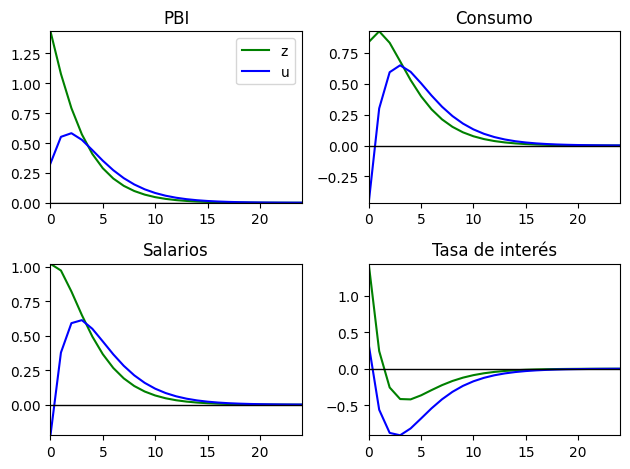

In [161]:
fig, axs = plt.subplots(2,2)
axs[0,0].plot(IRFy[0,:,0],'g')
axs[0,0].plot(IRFy[0,:,1],'b')
axs[0,0].axhline(0, color='k', lw=1)
axs[0,0].autoscale(enable=True, axis='both', tight=True)
axs[0,0].legend(['z', 'u'])
axs[0,0].set_title('PBI')

axs[0,1].plot(IRFy[1,:,0],'g')
axs[0,1].plot(IRFy[1,:,1],'b')
axs[0,1].axhline(0, color='k', lw=1)
axs[0,1].autoscale(enable=True, axis='both', tight=True)
axs[0,1].set_title('Consumo')

axs[1,0].plot(IRFy[4,:,0],'g')
axs[1,0].plot(IRFy[4,:,1],'b')
axs[1,0].axhline(0, color='k', lw=1)
axs[1,0].autoscale(enable=True, axis='both', tight=True)
axs[1,0].set_title('Salarios')

axs[1,1].plot(IRFy[5,:,0],'g')
axs[1,1].plot(IRFy[5,:,1],'b')
axs[1,1].axhline(0, color='k', lw=1)
axs[1,1].autoscale(enable=True, axis='both', tight=True)
axs[1,1].set_title('Tasa de interés')

plt.tight_layout()

In [ ]:
modelo = dict()
modelo['SLER'] = RBCveranoBCRP(param_0)

In [ ]:
modelo = DG.SolveDSGE(modelo)

In [ ]:
modelo = DG.get_StatesMat(modelo,True)
modelo = GenMeasureMat(modelo,np.array([[MEsdgdp**2],[MEsdinv**2]]))

(8, 10000)

In [ ]:
xsim.shape
#Objeto 8 * 10000
En este obtejo hay 8 parametros y estos tienen 10000 versiones quiero hacer lo de
 Kalman
modelo = dict()
modelo['SLER'] = RBCveranoBCRP(param_0) #inserto los 8 parametros aqui
modelo = DG.SolveDSGE(modelo)
modelo = DG.get_StatesMat(modelo,True)
modelo = GenMeasureMat(modelo,np.array([[MEsdgdp**2],[MEsdinv**2]]))
data = np.c_[gdp,inv]
ops = {'compute_stderrors':False,'a_initial':modelo['REE']['alpha0'].flatten(),'P_initial':modelo['REE']['Sigma_a0']}
mod_filtered = KF.KFplus(data,modelo['REE'],ops)
Todo lo hago 10000 veces una por cada version del conjunto de parametros dentro de ese xsimshape
#PBI
mod_filtered['a_s'][:,0] guardo solo esto de las simulaciones

me quedara una cosa gigante con 10000 versionesde lo de arriba,esas 10000 necesito sacar su mean ,y sus intervalos de confianza en base a esos 10000. Simplemente el percentil 97.5 y el 2.5


In [180]:
#PBI
mod_filtered['a_s'][:,0]

(112,)

In [186]:
    param_i = xsim[:, 1]


In [182]:
import numpy as np

# Suponiendo que xsim.shape es (8, 10000)
#    -> 8 parámetros x 10000 draws
n_params = xsim.shape[0]
n_draws  = xsim.shape[1]

# Construimos un arreglo para guardar 'a_s' filtrado (columna 0)
# Asumiendo que 'data' tiene T observaciones
T = data.shape[0]
all_a_s_0 = np.zeros((T, n_draws))

for i in range(n_draws):
    # 1) Extraer el vector de parámetros de la i-ésima iteración
    param_i = xsim[:, i]

    # 2) Construir y resolver el modelo con esos parámetros
    modelo = dict()
    modelo['SLER'] = RBCveranoBCRP(param_i)      # define RBCveranoBCRP con param_i
    modelo = DG.SolveDSGE(modelo)
    modelo = DG.get_StatesMat(modelo, True)
    MEsdgdp = np.std(gdp)*0.1
    MEsdinv = np.std(inv)*0.1
    modelo = GenMeasureMat(modelo, np.array([[MEsdgdp**2],[MEsdinv**2]]))

    # 3) Correr el Filtro de Kalman
    ops = {
        'compute_stderrors': False,
        'a_initial': modelo['REE']['alpha0'].flatten(),
        'P_initial': modelo['REE']['Sigma_a0']
    }
    mod_filtered = KF.KFplus(data, modelo['REE'], ops)

    # 4) Guardar la trayectoria filtrada de la variable 'a_s'[:, 0]
    #    Suponiendo que 'mod_filtered["a_s"]' es de dimensión (T, algo)
    all_a_s_0[:, i] = mod_filtered['a_s'][:, 0]

# ----------------------------------------------------------------------
# Una vez terminadas las 10000 iteraciones, tenemos:
# all_a_s_0 con shape (T, 10000)
# ----------------------------------------------------------------------

# 5) Calcular media y percentiles (2.5 y 97.5) en cada período.
mean_a_s_0 = np.mean(all_a_s_0, axis=1)  # -> vector de dimensión (T,)
p025_a_s_0 = np.percentile(all_a_s_0, 2.5,  axis=1)
p975_a_s_0 = np.percentile(all_a_s_0, 97.5, axis=1)




El equilibrio esta localmente indeterminado


LinAlgError: Singular matrix

In [189]:
import numpy as np

# Suponiendo que xsim.shape es (8, 10000)
n_draws  = xsim.shape[1]

# T es el número de observaciones del vector data (para KF)
T = data.shape[0]

# Inicializamos una matriz para almacenar los resultados
all_a_s_0 = np.zeros((T, n_draws))

valid_count = 0  # Para llevar la cuenta de cuántas corridas fueron válidas

for i in range(n_draws):
    # Extraer parámetros
    param_i = xsim[:, i]

    try:
        # Definir y resolver el modelo
        modelo = {}
        modelo['SLER'] = RBCveranoBCRP(param_i)
        modelo = DG.SolveDSGE(modelo)
        modelo = DG.get_StatesMat(modelo, True)

        MEsdgdp = np.std(gdp)*0.1
        MEsdinv = np.std(inv)*0.1
        modelo = GenMeasureMat(modelo, np.array([[MEsdgdp**2],[MEsdinv**2]]))

        # Correr el Filtro de Kalman
        ops = {
            'compute_stderrors': False,
            'a_initial': modelo['REE']['alpha0'].flatten(),
            'P_initial': modelo['REE']['Sigma_a0']
        }
        mod_filtered = KF.KFplus(data, modelo['REE'], ops)

        # Guardar el resultado (ej. a_s[:, 0])
        all_a_s_0[:, i] = mod_filtered['a_s'][:, 0]

        valid_count += 1  # Contamos como corrida válida

    except np.linalg.LinAlgError:
        # Omitimos la iteración si se produce un error de singularidad
        print(f"Iteración {i}: Singular matrix; saltando.")
        # Podrías poner all_a_s_0[:, i] = np.nan, si prefieres marcarlo con NaN
        # all_a_s_0[:, i] = np.nan
        continue

print(f"Se completaron {valid_count} corridas válidas de un total de {n_draws}.")


El equilibrio esta localmente indeterminado
Iteración 995: Singular matrix; saltando.
El equilibrio esta localmente indeterminado
Iteración 996: Singular matrix; saltando.
El equilibrio esta localmente indeterminado
Iteración 1084: Singular matrix; saltando.
El equilibrio esta localmente indeterminado
Iteración 1085: Singular matrix; saltando.
El equilibrio esta localmente indeterminado
Iteración 1086: Singular matrix; saltando.
El equilibrio esta localmente indeterminado
Iteración 1087: Singular matrix; saltando.
El equilibrio esta localmente indeterminado
Iteración 1093: Singular matrix; saltando.
El equilibrio esta localmente indeterminado
Iteración 1297: Singular matrix; saltando.
El equilibrio esta localmente indeterminado
Iteración 1379: Singular matrix; saltando.
El equilibrio esta localmente indeterminado
Iteración 1795: Singular matrix; saltando.
El equilibrio esta localmente indeterminado
Iteración 2747: Singular matrix; saltando.
El equilibrio esta localmente indeterminado
I

In [191]:
all_a_s_0.shape

(112, 10000)

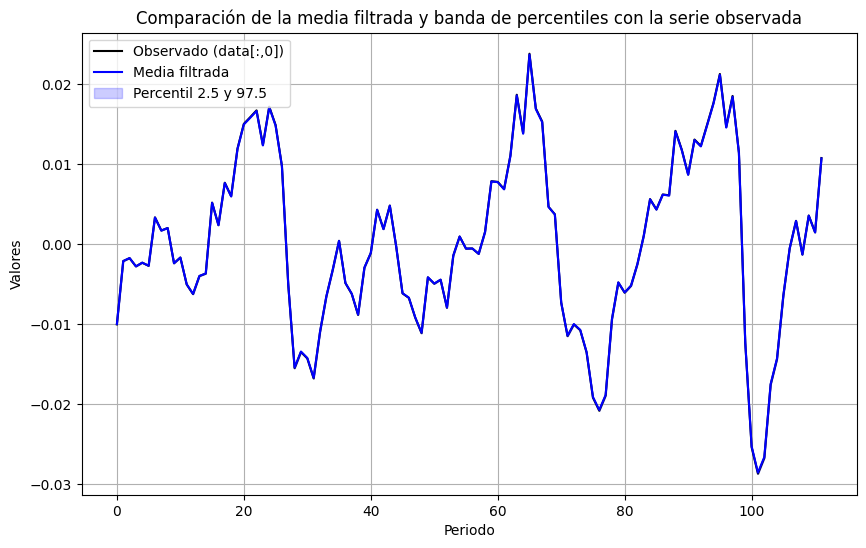

In [196]:
import numpy as np
import matplotlib.pyplot as plt

# Suponiendo que all_a_s_0.shape = (112, 10000)
# Cada fila (0..111) representa un periodo de tiempo,
# cada columna (0..9999) es una simulación o draw.

# 1) Calcular percentiles y media por fila
p2_5  = np.percentile(all_a_s_0, 2.5,  axis=1)   # array de longitud 112
p97_5 = np.percentile(all_a_s_0, 97.5, axis=1)   # array de longitud 112
mean_values = np.mean(all_a_s_0, axis=1)         # array de longitud 112

# 2) Graficar
plt.figure(figsize=(10,6))

# Eje temporal para 112 periodos (del 0 al 111)
t = np.arange(112)

# a) Graficar la serie observada (data[:,0])
plt.plot(t, data[:,0], label='Observado (data[:,0])', color='black')

# b) Graficar la media filtrada
plt.plot(t, mean_values, label='Media filtrada', color='blue')

# c) Rellenar el área entre p2.5 y p97.5 para mostrar la banda de confianza
plt.fill_between(t, p2_5, p97_5, color='blue', alpha=0.2,
                 label='Percentil 2.5 y 97.5')

# Leyenda y detalles estéticos
plt.title('Comparación de la media filtrada y banda de percentiles con la serie observada')
plt.xlabel('Periodo')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)

plt.show()


In [163]:
xsim.shape

(8, 10000)

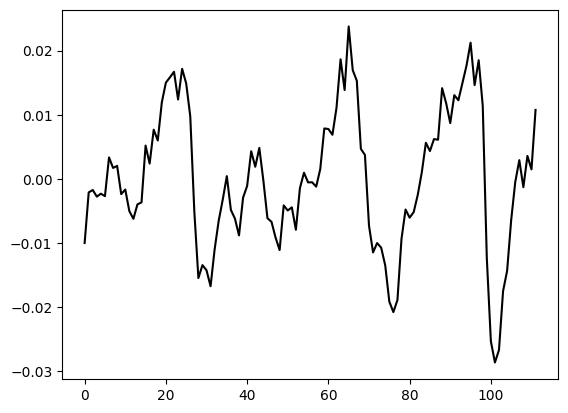

In [199]:
plt.plot(t, data[:,0], label='Observado (data[:,0])', color='black')
